# Time Transformer [`t2`] (mini) Analysis Pipeline

### Time Transformer Analysis Pipeline

Time Transformer is an attempt to apply the transformer architecture to time series. In this walk through I will use the **WISDM** (**WI**reless **S**ensor **D**ata **M**ining dataset: http://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf)
    

The purpose of this dataset is for multivariate time series classification, which is exactly the problem we are trying to solve for Type Ia Supernova. With Supernova classification we have observations accross 6 passbands for "each timestep". 

There is a ***disclaimer*** is since we don't _actually_ have measurements for all 6 'variables' for everytime step, but this can be resolved with a Gaussian Process regression for interpoloation of points between actual observed data.

Therefore we will use this dataset as a proof on concept to see if this type of architecture would be suitable for our problem too.

Below is a short video showing how data of this type is collected:

In [275]:
from IPython.display import HTML

HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/XOEN9W05_4A" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

### Load in the WISM dataset

See `astronet/t2/utils.py` for details

### Hyperparameter Optimisation

In [ ]:
# %load ../astronet/t2/opt/hypertrain.py
import joblib
import json
import logging
import numpy as np
import optuna
import subprocess
import sys
import tensorflow as tf
import warnings

from astronet.t2.model import T2Model
from astronet.t2.preprocess import one_hot_encode
from astronet.t2.transformer import TransformerBlock, ConvEmbedding
from astronet.t2.utils import t2_logger, load_WISDM
from keras.backend import clear_session
from pathlib import Path
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO,
        format='[%(asctime)s] {%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(filename='studies.log', mode='a'),
            logging.StreamHandler(sys.stdout)
        ]
)

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

try:
    log = t2_logger(__file__)
    log.info("_________________________________")
    log.info("File Path:" + str(Path(__file__).absolute()))
    log.info("Parent of Directory Path:" + str(Path().absolute().parent))
except:
    print("Seems you are running from a notebook...")
    __file__ = str(Path().resolve().parent) + "/astronet/t2/opt/hypertrain.py"

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


class Objective(object):
    def __init__(self, epochs, batch_size):
        self.epochs = EPOCHS
        self.batch_size = BATCH_SIZE

    def __call__(self, trial):
        # Clear clutter from previous Keras session graphs.
        clear_session()

        # Load WISDM-2010
        X_train, y_train, X_val, y_val, X_test, y_test = load_WISDM()
        # One hot encode y
        enc, y_train, y_val, y_test = one_hot_encode(y_train, y_val, y_test)

        embed_dim = trial.suggest_categorical("embed_dim", [32, 64])  # --> Embedding size for each token
        num_heads = trial.suggest_categorical("num_heads", [4, 8])  # --> Number of attention heads
        ff_dim = trial.suggest_categorical("ff_dim", [32, 64])  # --> Hidden layer size in feed forward network inside transformer

        num_filters = embed_dim  # --> Number of filters to use in ConvEmbedding block, should be equal to embed_dim

        input_shape = X_train.shape
        # print(input_shape[1:])  # --> (TIMESTEPS, num_features)

        model = T2Model(
            input_dim=input_shape,
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_filters=num_filters,
        )

        # We compile our model with a sampled learning rate.
        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
        model.compile(
            loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=lr), metrics=["acc"]
        )

        model.build_graph(input_shape)

        _ = model.fit(
            X_train,
            y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(X_val, y_val),
            verbose=False,
        )

        model.summary(print_fn=logging.info)

        # Evaluate the model accuracy on the validation set.
        # score = model.evaluate(X_val, y_val, verbose=0)
        score = model.evaluate(X_test, y_test, verbose=0)
        return score[1]


if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )

    import time
    unixtimestamp = int(time.time())
    label = subprocess.check_output(["git", "describe", "--always"]).strip().decode()

    BATCH_SIZE = 32
    EPOCHS = 2
    N_TRIALS = 3

    study = optuna.create_study(study_name=f"{unixtimestamp}", direction="maximize")
    study.optimize(Objective(epochs=EPOCHS, batch_size=BATCH_SIZE), n_trials=N_TRIALS, timeout=1000)

    best_result = {}
    best_result['name'] = str(unixtimestamp) + "-" + label

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial
    df_study = study.trials_dataframe()
    print(df_study.head())

    print("  Value: {}".format(trial.value))
    best_result['value'] = trial.value

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        # best_result["{}".format(key)] = value

    best_result.update(study.best_params)
    print(best_result)

    with open(f"{Path(__file__).absolute().parent}/runs/results.json") as jf:
        data = json.load(jf)
        print(data)

        previous_results = data['optuna_result']
        # Appending data to optuna_result
        print(previous_results)
        previous_results.append(best_result)
        print(previous_results)
        print(data)

    with open(f"{Path(__file__).absolute().parent}/runs/results.json", "w") as rf:
        json.dump(data, rf, sort_keys=True, indent=4)

    with open(f"{Path(__file__).absolute().parent}/runs/study-{unixtimestamp}-{label}.pkl", "wb") as sf:
        joblib.dump(study, sf)



{'optuna_result': [{'embed_dim': 64, 'ff_dim': 64, 'lr': 1.0177587329216099e-05, 'name': '1601414722-61e4279', 'num_heads': 8, 'value': 0.4232456088066101}, {'embed_dim': 32, 'ff_dim': 64, 'lr': 0.025068014761509952, 'name': '1601415144-61e4279', 'num_heads': 8, 'value': 0.844298243522644}, {'embed_dim': 32, 'ff_dim': 32, 'lr': 0.00043582562154232773, 'name': '1601415853-db5b25f', 'num_heads': 4, 'value': 0.8347952961921692}, {'embed_dim': 32, 'ff_dim': 32, 'lr': 0.00248456740788535, 'name': '1601416703-db5b25f', 'num_heads': 8, 'value': 0.8252924084663391}, {'embed_dim': 64, 'ff_dim': 64, 'lr': 0.0019238749892858292, 'name': '1601418367-db5b25f', 'num_heads': 4, 'value': 0.8311403393745422}, {'embed_dim': 64, 'ff_dim': 64, 'lr': 0.00012884204384320448, 'name': '1601573089-ed0e3cd', 'num_heads': 8, 'value': 0.7828947305679321}, {'embed_dim': 64, 'ff_dim': 32, 'lr': 0.0027982876473248764, 'name': '1601638100-4156e2d', 'num_heads': 8, 'value': 0.8333333134651184}, {'embed_dim': 32, 'ff_

Lets now inspect this hyperparameter optimisation run.

We will first load in this study like so:

In [47]:
study_name = f"{unixtimestamp}-{label}"
with open(f"{Path(__file__).absolute().parent}/runs/study-{study_name}.pkl", "rb") as sf:
    study = joblib.load(sf)

In [49]:
# # To load the best performing study out of all studies completed so far, one can run:
# with open(f"{Path(__file__).absolute().parent}/runs/results.json") as f:
#     events = json.load(f)
#     event = max(events['optuna_result'], key=lambda ev: ev['value'])
#     print(event)
    
# # Where study_name would be set via event['name'] like so:
# study_name = event['name']

{'embed_dim': 32, 'ff_dim': 64, 'lr': 0.025068014761509952, 'name': '1601415144-61e4279', 'num_heads': 8, 'value': 0.844298243522644}


In [48]:
from optuna.visualization import *
import matplotlib.pyplot as plt
%matplotlib inline

plot_parallel_coordinate(study)

In [36]:
plot_optimization_history(study)

In [45]:
plot_contour(study, params=['embed_dim',
                            'ff_dim', 
                            'num_heads'])

[2020-10-02 13:37:37,986] {_contour.py:173} WARNING - Param embed_dim unique value length is less than 2.
[2020-10-02 13:37:37,991] {_contour.py:173} WARNING - Param embed_dim unique value length is less than 2.
[2020-10-02 13:37:37,998] {_contour.py:176} WARNING - Param embed_dim unique value length is less than 2.
[2020-10-02 13:37:38,010] {_contour.py:176} WARNING - Param embed_dim unique value length is less than 2.


In [46]:
plot_slice(study)

Now let's train on the best performing study of all hyperparamter optimsation studies. See above for details.

In [ ]:
# %load ../astronet/t2/train.py
import json
import logging
import numpy as np
import subprocess
import tensorflow as tf
import time

from keras.backend import clear_session
from pathlib import Path
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
from tensorflow.keras import layers, optimizers

from astronet.t2.model import T2Model
from astronet.t2.preprocess import one_hot_encode
from astronet.t2.transformer import TransformerBlock, ConvEmbedding
from astronet.t2.utils import t2_logger, load_WISDM

try:
    log = t2_logger(__file__)
    log.info("_________________________________")
    log.info("File Path:" + str(Path(__file__).absolute()))
    log.info("Parent of Directory Path:" + str(Path().absolute().parent))
except:
    print("Seems you are running from a notebook...")
    __file__ = str(Path().resolve().parent) + "/astronet/t2/train.py"

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

class Training(object):
    def __init__(self, epochs, batch_size):
        self.epochs = epochs
        self.batch_size = batch_size

    def __call__(self):
        # Load WISDM-2010
        X_train, y_train, X_val, y_val, X_test, y_test = load_WISDM()
        # One hot encode y
        enc, y_train, y_val, y_test = one_hot_encode(y_train, y_val, y_test)

        log.info(print(X_train.shape, y_train.shape))
        # print(X_val.shape, y_val.shape)
        # print(X_test.shape, y_test.shape)

        with open(str(Path().absolute()) + '/opt/runs/results.json') as f:
            events = json.load(f)
            event = max(events['optuna_result'], key=lambda ev: ev['value'])
            print(event)

        embed_dim = event['embed_dim']  # --> Embedding size for each token
        num_heads = event['num_heads']  # --> Number of attention heads
        ff_dim = event['ff_dim']  # --> Hidden layer size in feed forward network inside transformer

        # --> Number of filters to use in ConvEmbedding block, should be equal to embed_dim
        num_filters = embed_dim

        input_shape = X_train.shape
        # print(input_shape[1:])  # (TIMESTEPS, num_features)

        model = T2Model(
            input_dim=input_shape,
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_filters=num_filters,
        )

        # We compile our model with a sampled learning rate.
        lr = event['lr']
        model.compile(
            loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=lr), metrics=["acc"]
        )

        model.build_graph(input_shape)

        history = model.fit(
                X_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(X_val, y_val),
                verbose=False,
                )

        print("HEEEEEEEERE")
        model.summary(print_fn=logging.info)

        print(model.evaluate(X_test, y_test))

        unixtimestamp = int(time.time())
        label = subprocess.check_output(["git", "describe", "--always"]).strip().decode()

        model_params = {}
        model_params['name'] = str(unixtimestamp) + "-" + label
        model_params['hypername'] = event['name']
        model_params['embed_dim'] = event['embed_dim']
        model_params['ff_dim'] = event['ff_dim']
        model_params['num_heads'] = event['num_heads']
        model_params['lr'] = event['lr']
        model_params['value'] = model.evaluate(X_test, y_test)[1]
        print("  Params: ")
        for key, value in history.history.items():
            print("    {}: {}".format(key, value))
            model_params["{}".format(key)] = value

        with open(f"{Path(__file__).absolute()}/models/results.json") as jf:
            data = json.load(jf)
            print(data)

            previous_results = data['training_result']
            # appending data to optuna_result
            print(previous_results)
            previous_results.append(model_params)
            print(previous_results)
            print(data)

        with open(f"{Path(__file__).absolute()}/models/results.json", "w") as rf:
            json.dump(data, rf, sort_keys=True, indent=4)

        model.save(f"{Path(__file__).absolute()}/models/model-{unixtimestamp}-{label}")

if __name__ == "__main__":

    BATCH_SIZE = 32
    EPOCHS = 2

    training = Training(epochs=EPOCHS, batch_size=BATCH_SIZE)
    training()

In [55]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [56]:
# %load ../astronet/t2/evaluate.py
import json
import numpy as np
import pandas as pd
import tensorflow as tf

from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras

from astronet.t2.utils import t2_logger, load_WISDM
from astronet.t2.preprocess import one_hot_encode
from astronet.t2.preprocess import robust_scale, one_hot_encode

try:
    log = t2_logger(__file__)
    log.info("_________________________________")
    log.info("File Path:" + str(Path(__file__).absolute()))
    log.info("Parent of Directory Path:" + str(Path().absolute().parent))
except:
    print("Seems you are running from a notebook...")
    __file__ = str(Path().resolve().parent) + "/astronet/t2/evaluate.py"

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Load WISDM-2010
X_train, y_train, X_val, y_val, X_test, y_test = load_WISDM()
# One hot encode y
enc, y_train, y_val, y_test = one_hot_encode(y_train, y_val, y_test)

with open(str(Path(__file__).absolute().parent) + '/models/results.json') as f:
    events = json.load(f)
    event = max(events['training_result'], key=lambda ev: ev['value'])
    print(event)

model_name = event['name']

model = keras.models.load_model(str(Path(__file__).absolute().parent) + f"/models/model-{model_name}")

model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
print(cm / np.sum(cm, axis=1, keepdims=1))

print("             Results for Test Set\n\n" +
      classification_report(enc.inverse_transform(y_pred),
                            enc.inverse_transform(y_test)))


Seems you are running from a notebook...
{'acc': [0.7839252948760986, 0.8354280591011047], 'embed_dim': 32, 'ff_dim': 64, 'hypername': '1601415144-61e4279', 'loss': [0.598563551902771, 0.42252492904663086], 'lr': 0.025068014761509952, 'name': '1601572110-ed0e3cd', 'num_heads': 8, 'val_acc': [0.6701506972312927, 0.720223605632782], 'val_loss': [0.8713304400444031, 0.865023672580719], 'value': 0.8304093480110168}
43/43 [==============================] - ETA: 0s - loss: 2.1094 - acc: 0.093 - ETA: 1s - loss: 2.4455 - acc: 0.046 - ETA: 1s - loss: 2.4419 - acc: 0.072 - ETA: 1s - loss: 1.8212 - acc: 0.387 - ETA: 1s - loss: 1.5533 - acc: 0.479 - ETA: 1s - loss: 1.3314 - acc: 0.553 - ETA: 1s - loss: 1.1476 - acc: 0.645 - ETA: 1s - loss: 0.9868 - acc: 0.698 - ETA: 1s - loss: 0.9132 - acc: 0.724 - ETA: 1s - loss: 0.8500 - acc: 0.745 - ETA: 1s - loss: 0.7477 - acc: 0.777 - ETA: 1s - loss: 0.7010 - acc: 0.791 - ETA: 1s - loss: 0.6597 - acc: 0.803 - ETA: 1s - loss: 0.5903 - acc: 0.824 - ETA: 1s - lo

In [2]:
from astronet.t2.visuals import *

In [3]:
try:
    log = t2_logger(__file__)
    log.info("_________________________________")
    log.info("File Path:" + str(Path(__file__).absolute()))
    log.info("Parent of Directory Path:" + str(Path().absolute().parent))
except:
    print("Seems you are running from a notebook...")
    __file__ = str(Path().resolve().parent) + "/astronet/t2/visuals.py"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

mpl.style.use("seaborn")


# Load WISDM-2010
X_train, y_train, X_val, y_val, X_test, y_test = load_WISDM()
# One hot encode y
enc, y_train, y_val, y_test = one_hot_encode(y_train, y_val, y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

with open(str(Path(__file__).absolute().parent) + '/models/results.json') as f:
    events = json.load(f)
    # Get params for best model with highest test accuracy
    event = max(events['training_result'], key=lambda ev: ev['value'])
    print(event)

model_name = event['name']

model = keras.models.load_model(str(Path(__file__).absolute().parent) + f"/models/model-{model_name}")

y_pred = model.predict(X_test)

Seems you are running from a notebook...
(21960, 200, 3) (21960, 6)
(4114, 200, 3) (4114, 6)
(1368, 200, 3) (1368, 6)
{'acc': [0.7839252948760986, 0.8354280591011047], 'embed_dim': 32, 'ff_dim': 64, 'hypername': '1601415144-61e4279', 'loss': [0.598563551902771, 0.42252492904663086], 'lr': 0.025068014761509952, 'name': '1601572110-ed0e3cd', 'num_heads': 8, 'val_acc': [0.6701506972312927, 0.720223605632782], 'val_loss': [0.8713304400444031, 0.865023672580719], 'value': 0.8304093480110168}


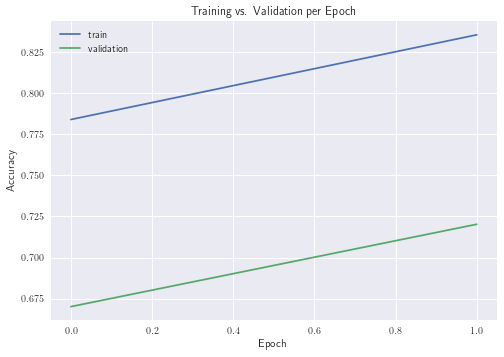

In [4]:
plot_history(model_name, event, save=False)

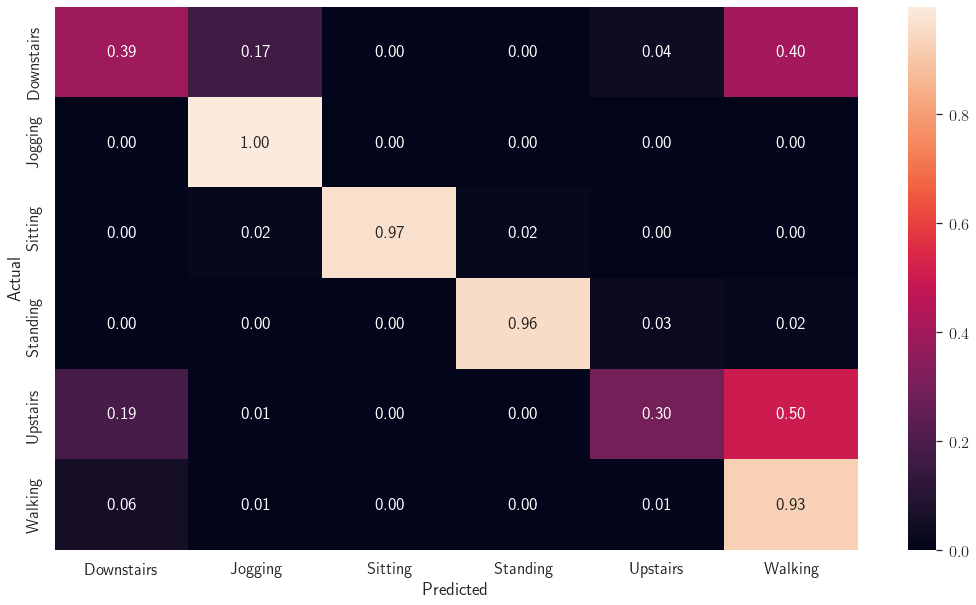

In [5]:
plot_confusion_matrix(
        model_name,
        enc.inverse_transform(y_test),
        enc.inverse_transform(y_pred),
        enc.categories_[0], 
        save=False
    )

Downstairs
<class 'numpy.ndarray'>


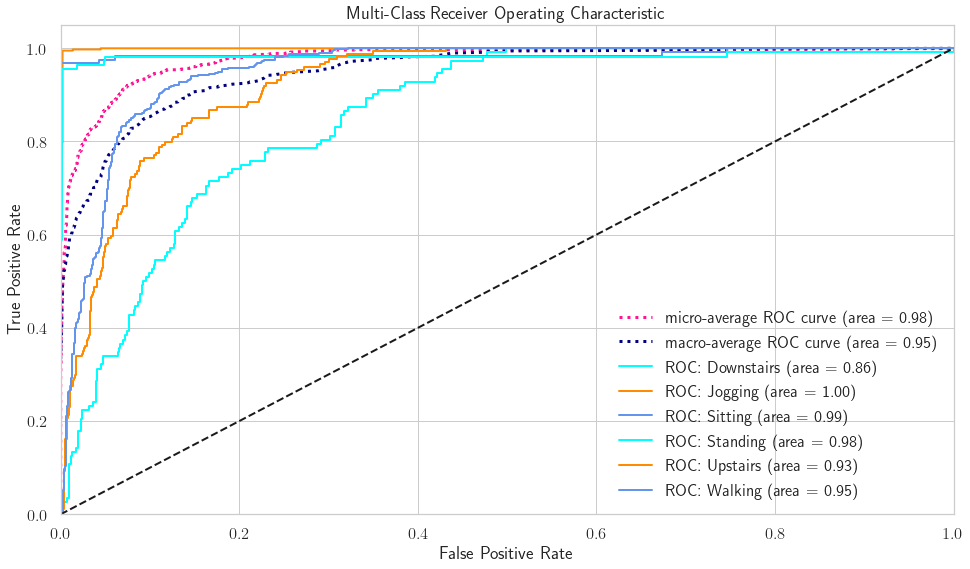

In [6]:
plot_multiROC(model_name, model, X_test, y_test, enc, save=False)

As mentioned in the [WISDM website](http://www.cis.fordham.edu/wisdm/dataset.php) the dataset can be describes as follows:
    
**Raw Time Series Data**
- Number of examples: 1,098,207
- Number of attributes: 6
- Missing attribute values: None

**Class Distribution**
- Walking: 424,400 (38.6%)
- Jogging: 342,177 (31.2%)
- Upstairs: 122,869 (11.2%)
- Downstairs: 100,427 (9.1%)
- Sitting: 59,939 (5.5%)
- Standing: 48,395 (4.4%)

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

In order to work with this data, we will need to do some pre-processing such that all axis are scaled correctly.

Furthermore there is another bit of "pre-processing" required such that we can use `keras` library for Deep Learning and classification. We need to split our dataset into a _train_ and _test_ (and _validation_) set and we will need to **one-hot** encode our targets.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets. With time-series data, it is very important not to allow for data to overlap from train to test, i.e we want to avoid the dreaded data leakage problem.

For this we shall first split the data into a train/val/test set, and _then_ apply a windowing function to create small time segments we can then use for training and testing

What we have now is a dataset of the shape above: (22454, 200, 3) (22454, 6) for `X_train` and `y_train` respectivly. 

This is to say we have 22452 _batches_, that are 200 time-step windows, that contain 3 variables each, i.e. `x, y, z` measurements. As you may have guess alreeady, this could be translated to X-number of _batches_, that are X-*MJD* day length windows, each containing 6 pass-band filter measurements.

## What is the Transformer achitecture?

The overall architecture of the Transformer network can be seen below. It consists of the _encoder_ section and a _decoder_ section

<img src="./images/transformer-arch.png" height=40% width=40%>

In the first instance, we will implement just the _encoder_ section show here and add a softmax output:

<img src="./images/transformer-arch-encoder.png" height=30% width=30%>

Depending on results and if we are able to get the inputs to behave, we will move towards development and analysis of the full Transformer architecture for time series.

The above can be seen pictorially as follows:
<img src="./images/transformer-arch-multihead.png" height=30% width=30%>

## Adapting the Transformer for Time-Series

The Transformer architeecture was originally applied to NLP tasks of translation. For this, there were specific stages in the pipeline that are focused towards working with words. For example, the embedding layer would project each word into a high-dimensional vector space followed by a positional enciding layer to ensure sequential information is preversed.

In the case of time-series, a simple Dese layer can be used to map the (`m, T, 6`)(batch, time-steps, features) into a (`m, 32`)(batch, time-steps x features). In `keras`, in order to apply a Dense layer to each input in the time sequence, there is `TimeDistributed` layer.  

From "Hands-On Machine Learning" by Aurelien Geron

> The `TimeDistributed` layer wraps any layer (e.g. `Dense` layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a seperate instance ( i.e, it reshapes the inputs from [*batch size, time-steps, input dimension*] to [*batch size x time-steps, input dimensions].

...
> The `Dense` layer actually supports sequences as inputs (and even higher dimensional inputs): it handles them just like `TimeDistributed(Dense(...))`, meaning it is applied to the last input dimension only (independently accross all time steps). Thus, we could just replace ... with just `Dense(..)`

> Note that a `TimeDistributed(Dense(n))` layer is equivalent to a `Conv1D(n, filter_size=1)` layer.

* https://keras.io/api/layers/convolution_layers/convolution1d/
* https://keras.io/api/layers/recurrent_layers/time_distributed/

##### But what is a 1-D convolition I hear you cry!?

In [195]:
from IPython.display import HTML

HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/vcp0XvDAX68" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

## Comparison to baseline models other approaches

The results above are at least comparable to other experimental results by [Jennifer R. Kwapisz et al 2010](https://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf) where their best reported model of an MLP achieved acc ~ 91%. With notablly better confusion matrix on our part. See tables below:

<img src="images/wisdm-2010-table2.png" height=40% width=40%>

<img src="images/wisdm-2010-table5.png" height=40% width=40%>

Another piece of work that is work comparing against is the analysis done by Jason Brownlee found [here](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)

The scope of that analysis was to evaluate deep learning methods for a similiar HAR dataset, namely the [Human Activity Recognition Using Smartphones Data Set, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)

> The raw data is not available. Instead, a pre-processed version of the dataset was made available. The pre-processing steps included:

> Pre-processing accelerometer and gyroscope using noise filters.
Splitting data into fixed windows of 2.56 seconds (128 data points) with 50% overlap.Splitting of accelerometer data into gravitational (total) and body motion components.
Feature engineering was applied to the window data, and a copy of the data with these engineered features was made available.

> A number of time and frequency features commonly used in the field of human activity recognition were extracted from each window. The result was a 561 element vector of features.

> The dataset was split into train (70%) and test (30%) sets based on data for subjects, e.g. 21 subjects for train and nine for test.

> Experiment results with a support vector machine intended for use on a smartphone (e.g. fixed-point arithmetic) resulted in a predictive accuracy of 89% on the test dataset, achieving similar results as an unmodified SVM implementation.

Jason Brownlee was able to get results on the order of ~ 90% for:
- LSTM --> Accuracy: 89.722% (+/-1.371)
- CNN+LSTM --> Accuracy: 90.689% (+/-1.051)
- ConvLSTM --> Accuracy: 90.801% (+/-0.886)

It is felt that with further training and better hyperparameter optimisation, better can be achieved, but it has been kept in mind that the cope of this analysis is proof of concept.

As such, we will move on to exploring the updated version of **WISDM** released recently.

## WISDM-2019

In late 2019, an [updated **WISDM** dataset](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+) was release which included 18 categories with many more observations. It is a big imporovement on the previous dataset, with balanced class distributions shown in table 4 of the [paper](https://archive.ics.uci.edu/ml/machine-learning-databases/00507/WISDM-dataset-description.pdf) and visualised below:

## References

#### Papers:


#### Weblinks:

* [The llustrated Transformer](http://jalammar.github.io/illustrated-transformer/)


#### TODO

   1. Implement a custom callback
   2. ~~Compare LSTM of blog post~~
   3. Put code into t2 files
   4. Explain dimensions, give examples. Windowing etc. use TF time_series.ipynb notebooks as example
       - Build WindowGenerator, time_series.ipynb notebook for examples
   5. Give in-depth explaination to adaption for time-series with relation to Transformer achitecture, use http://nlp.seas.harvard.edu/2018/04/03/attention.html and https://srome.github.io/Understanding-Attention-in-Neural-Networks-Mathematically/ as well as http://jalammar.github.io/illustrated-transformer/ and https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/13.time-series-human_activity_recognition.ipynb as reference
   6. Add table of contents to this notebook